<a href="https://colab.research.google.com/github/rghosh1353/cancer_epifactors/blob/main/NeuralNetworkModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import operator
import statistics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Prepare Data (Encoding Predictor Variable, Splitting Data, Normalization)

In [23]:
# read in pediatric cancer data
dataframe = pd.read_csv("cancer_counts.csv")
# remove first column (contained name/barcode of samples)
dataframe = dataframe.iloc[:, 1:]

In [5]:
# separate gene expression data features from cancer outcome
X = dataframe.iloc[:, 0:-1]
y = dataframe.iloc[:, -1]

In [6]:
# convert predictor categorical variable into numeric labels for the model
convert = LabelEncoder()
convert.fit(y)
y = convert.transform(y)

# normalize values within range (0, 1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [7]:
# create training, testing and validation sets
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

# Create Neural Network Model

In [8]:
# find number of input and output
n_input = X_train.shape[1]
n_output = dataframe.cancer_type.nunique()

# create layers
model = Sequential()
model.add(Dense(35, input_dim = n_input, activation = "relu", name = "HiddenLayer1")) # use relu for both hidden layers (usually default for hidden layers)
model.add(Dense(20, activation = "relu", name = "HiddenLayer2"))
model.add(Dense(n_output, activation = "softmax", name = "OutputLayer")) # use softmax since we are working with multiclass classification

# compile model
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = Adam(learning_rate = 0.0001), metrics = keras.metrics.SparseCategoricalAccuracy())


In [9]:
# fit model to training set
fitting = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 25, epochs = 200, verbose = 0)

# Evaluation of Model

In [10]:
# neural network model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer1 (Dense)        (None, 35)                18410     
                                                                 
 HiddenLayer2 (Dense)        (None, 20)                720       
                                                                 
 OutputLayer (Dense)         (None, 5)                 105       
                                                                 
Total params: 19235 (75.14 KB)
Trainable params: 19235 (75.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


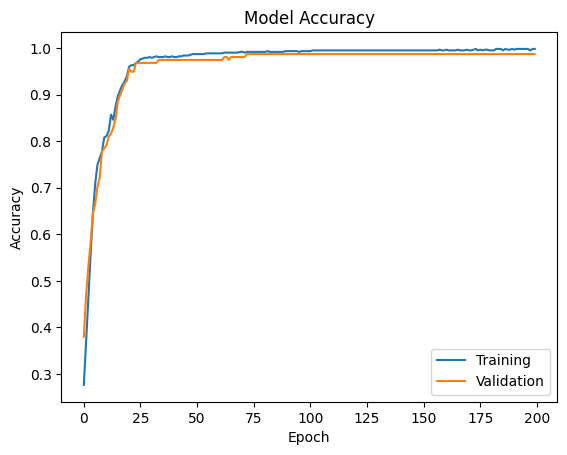

In [11]:
# plot model accuracy
plt.plot(fitting.history["sparse_categorical_accuracy"]) # training accuracy
plt.plot(fitting.history["val_sparse_categorical_accuracy"]) # validation accuracy
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training", "Validation"], loc = "lower right")
plt.show()

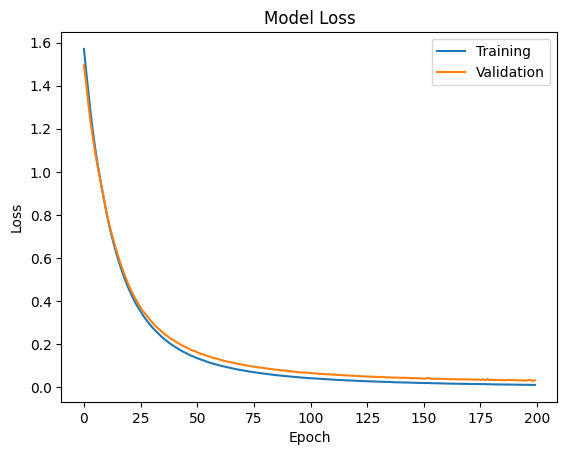

In [12]:
# plot model loss
plt.plot(fitting.history["loss"])
plt.plot(fitting.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"], loc = "upper right")
plt.show()

In [58]:
# evaluate performance for training, testing, validation and all data
scores = model.evaluate(X_train, y_train, verbose = 0)
print("\nTraining Data Accuracy: %.2f%%" % (scores[1]*100))

scores = model.evaluate(X_test, y_test, verbose = 0)
print("\nTesting Data Accuracy: %.2f%%" % (scores[1]*100))

scores = model.evaluate(X_val, y_val, verbose = 0)
print("\nValidation Data Accuracy: %.2f%%" % (scores[1]*100))

scores = model.evaluate(X, y, verbose = 0)
print("\nOverall Data Accuracy: %.2f%%" % (scores[1]*100))


Training Data Accuracy: 99.84%

Testing Data Accuracy: 99.49%

Validation Data Accuracy: 98.73%

Overall Data Accuracy: 99.59%


# Evaluation of Feature Weights

Median Feature Weight:  2.2110953


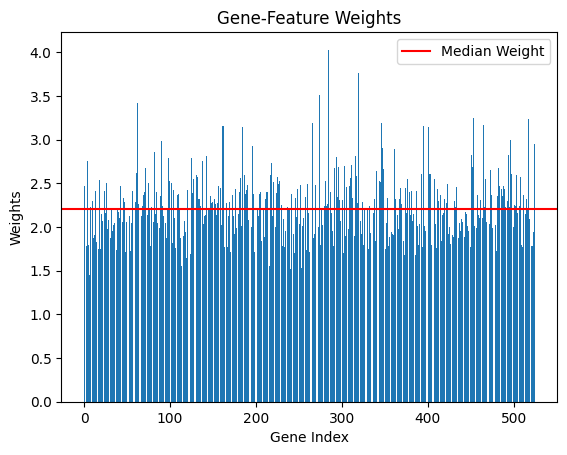

In [69]:
# bar plot of weights for each gene
weights = model.get_weights()
feature_importance = np.sum(np.abs(weights[0]), axis=1)

# median weight
median = statistics.median(feature_importance)
print("Median Feature Weight: ", median)

plt.bar(x = range(0, n_input, 1), height = feature_importance)
plt.axhline(y=median, color='r', linestyle='-', label = "Median Weight")
plt.title("Gene-Feature Weights")
plt.xlabel("Gene Index")
plt.ylabel("Weights")
plt.legend()
plt.show()

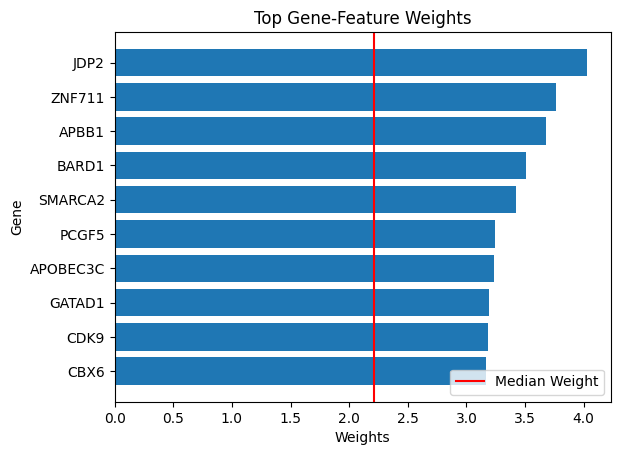

In [73]:
# sort genes based on descending weights
genes = dataframe.columns

gene_weight = dict(map(lambda i, j : (i, j) , genes, feature_importance))
sorted_gene_weight = dict(sorted(gene_weight.items(), key = operator.itemgetter(1), reverse = True))

# show top 10 highest gene weights
top_10 = dict(sorted(gene_weight.items(), key = operator.itemgetter(1), reverse = True)[:10])

names = list(top_10.keys())
values = list(top_10.values())

plt.barh(range(len(top_10)), values, tick_label = names)
plt.gca().invert_yaxis()
plt.axvline(x = median, color='r', linestyle='-', label = "Median Weight")
plt.xlabel("Weights")
plt.ylabel("Gene")
plt.title("Top Gene-Feature Weights")
plt.legend(loc = "lower right")
plt.show()